In [1]:
import pandas as pd
import networkx as nx
import regex as re
import fuzzywuzzy
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import ast

In [2]:
net_meta = nx.read_gexf("graph_meta.gexf")
df_ner = pd.read_csv('results/NLP_24-01-23_lg_1933r_19448n.csv')#, engine='python')
net_ner = nx.DiGraph()

In [3]:
def is_prox(word1, word2):
    word1 = re.sub(r'.+\.', '', word1)
    word2 = re.sub(r'.+\.', '', word2)
    ratio = fuzz.token_sort_ratio(word1.lower(), word2.lower())
    partial_ratio = fuzz.partial_ratio(word1.lower(), word2.lower())
    if ratio > 80 or partial_ratio > 80:
        return(True)
    else:
        return(False)

In [4]:
# nb_a_traiter = 100
nb_a_traiter = len(df_ner.index)

# for i in range(len(df.index)):
for i in range(nb_a_traiter):
    extracted_name = df_ner['extracted_names'][i]
    recognized_names = ast.literal_eval(df_ner['pers'][i])
    num_letters = len(re.findall(r"[a-z]", extracted_name.lower()))
    geniune = ''
    if num_letters < 5 or len(extracted_name) >= 25:
        continue
    
    # Rapprochement éventuel avec la vraie orthographe issue du graph_meta
    for node in net_meta:
        if len(node) > 3 & is_prox(extracted_name, node) == True:
            extracted_name = node
            geniune = 'geniune'

    # Peuplement de net_ner d'un premier node pour pouvoir boucler dedans
    if not net_ner:
        net_ner.add_node(extracted_name, from_=f'sign_{geniune}')
    
    # Peuplement de net_ner de nos auteurs. Si déjà présent on ne le créé pas
    detected = False
    for node in net_ner.copy():
    # for node in nodes_test:
        if is_prox(extracted_name, node) == True:
            extracted_name = node
            detected = True
            break
    if detected == False:
        net_ner.add_node(extracted_name, from_=f'sign_{geniune}')
    
    # À partir d'ici extracted_name EST LOCKÉ -> il est dans net_ner, il est le node DE DÉPART de notre lien
    geniune = False # doit être en False pour tous les éventuels nodes qui seront créés
    # Pour chaque nom NER
    for recognized_name in recognized_names:
        # On checke si node ressemblant existe déjà dans le graph (pour que 'Virgile' et 'Virgil' soient la même personne)
        detected = False
        for node in net_ner.copy():
            if is_prox(recognized_name, node) == True:
                detected = True
                recognized_name = node
                break
        if detected == False:
            net_ner.add_node(recognized_name, from_='ner')

        # À partir d'ici recognized_name EST LOCKÉ -> il est dans net_ner, il est le node D'ARRIVÉE de notre lien
        if net_ner.has_edge(extracted_name, recognized_name):
            net_ner[extracted_name][recognized_name]["weight"] += 1
        else:
            net_ner.add_edge(extracted_name, recognized_name, weight=1)

In [5]:
net_ner.remove_edges_from(nx.selfloop_edges(net_ner))
# G.remove_edges_from(list(nx.selfloop_edges(G)))
nx.write_gexf(net_ner, f"graph_ner_{nb_a_traiter}.gexf")

5383


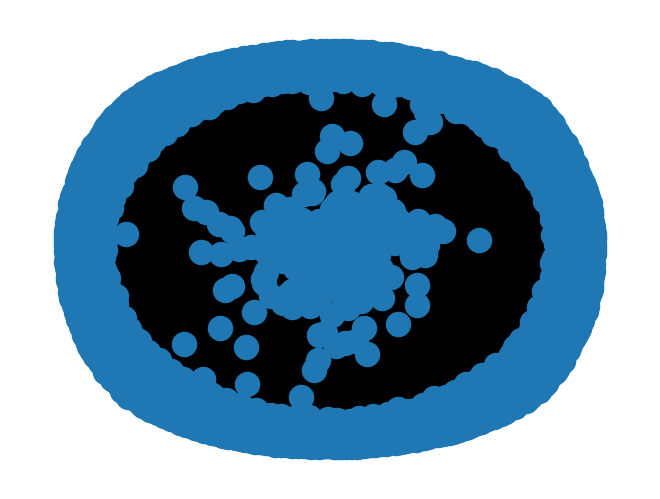

In [6]:
print(len(net_ner))
nx.draw(net_ner)